In [166]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.constants import DATASETS_FOLDER_PATH
from Utils.data_utils import load_preprocessed_data_from_folder

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold


# Courses Packages
from Utils.DataVisualization import PlotConfusionMatrix, PlotLabelsHistogram, PlotBinaryClassData

# Model
from sklearn.naive_bayes import GaussianNB


# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

# Separate features (X) and labels (y) from the loaded data
mX = data.drop(columns=["Potability"])  # Exclude the label column if it's included in the data
vY = data["Potability"]  # Extract the label column

# Now you can use X and y for further training

In [167]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000
mean,0.505311,0.539229,0.356850,0.530729,0.581404,0.427316,0.462487,0.533157,0.475886,0.500000
std,0.102383,0.117732,0.142762,0.122167,0.107484,0.139168,0.125155,0.126553,0.144599,0.500063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.445069,0.469368,0.254508,0.454815,0.521145,0.324846,0.378726,0.454280,0.378779,0.000000
50%,0.503327,0.540575,0.339079,0.531114,0.581081,0.420330,0.458965,0.534191,0.472306,0.500000
75%,0.564544,0.611621,0.443330,0.606549,0.642954,0.523981,0.547767,0.616287,0.574892,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [168]:
# Parameters
lCriterion   = ['gini', 'entropy', 'log_loss'] #<! List
lMaxLeaf     = list(range(5, 11)) #<! List

# Data
numSamplesRatio = 0.2

mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = numSamplesRatio, shuffle = True, stratify = vY)

In [169]:
# Train Test Split

print(f'The training features data shape: {mXTrain.shape}')
print(f'The training labels data shape: {vYTrain.shape}')
print(f'The test features data shape: {mXTest.shape}')
print(f'The test labels data shape: {vYTest.shape}')
print(f'The unique values of the labels: {np.unique(vY)}')

The training features data shape: (3196, 9)
The training labels data shape: (3196,)
The test features data shape: (800, 9)
The test labels data shape: (800,)
The unique values of the labels: [0. 1.]


## Classifier Model

Bootstrap Aggregating (Bagged) decision tree
Bagging involves training multiple decision trees on bootstrapped samples of the training data and then aggregating their predictions.  

In [170]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: You may use iteration tools for create the cartesian product.
numComb = len(lCriterion) * len(lMaxLeaf) #<! Number combinations
dData   = {'Criterion': [], 'Max Leaves': [], 'F1': [0.0] * numComb} #<! Dictionary (To create the DF from)

for ii, paramCriteria in enumerate(lCriterion):
    for jj, maxLeaf in enumerate(lMaxLeaf):
        dData['Criterion'].append(paramCriteria)
        dData['Max Leaves'].append(maxLeaf)
#===============================================================#

# The DF: Each row is a combination to evaluate.
# The columns are the parameters and the F1 score.
dfModelScore = pd.DataFrame(data = dData)

# Display the DF
dfModelScore

,Criterion,Max Leaves,F1
0,gini,5,0.0
1,gini,6,0.0
2,gini,7,0.0
3,gini,8,0.0
4,gini,9,0.0
5,gini,10,0.0
6,entropy,5,0.0
7,entropy,6,0.0
8,entropy,7,0.0
9,entropy,8,0.0


In [171]:
# # Optimize the Model

# #===========================Fill This===========================#
# # 1. Iterate over each row of the data frame `dfModelScore`. Each row defines the hyper parameters.
# # 2. Construct the model.
# # 3. Train it on the Train Data Set.
# # 4. Calculate the score.
# # 5. Store the score into the data frame column.

# for ii in range(numComb):
#     paramCriteria    = dfModelScore.loc[ii, 'Criterion']
#     maxLeaf          = dfModelScore.loc[ii, 'Max Leaves']

#     print(f'Processing model {ii + 1:03d} out of {numComb} with `criterion` = {paramCriteria} and `max_leaf_nodes` = {maxLeaf}.')

#     oDecTreeCls = DecisionTreeClassifier(criterion = paramCriteria, max_leaf_nodes = maxLeaf) #<! The model with the hyper parameters of the current combination
    
#     vYPred = cross_val_predict(oDecTreeCls, mXTrain, vYTrain, cv = KFold(n_splits = mXTrain.shape[0])) #<! Predict by cross validation

#     f1Score = f1_score(vYTrain, vYPred)
#     dfModelScore.loc[ii, 'F1'] = f1Score
#     print(f'Finished processing model {ii + 1:03d} with `f1 = {f1Score}.')
# #===============================================================#

In [172]:
# # Display Sorted Results (Descending)
# dfModelScore.sort_values(by = ['F1'], ascending = False).head(10)

In [173]:
# # Extract the Optimal Hyper Parameters

# idxArgMax = dfModelScore['F1'].idxmax()
# #===============================================================#

# optimalCriterion = dfModelScore.loc[idxArgMax, 'Criterion']
# optimalMaxLeaf   = dfModelScore.loc[idxArgMax, 'Max Leaves']

# print(f'The optimal hyper parameters are: `criterion` = {optimalCriterion}, `max_leaf_nodes` = {optimalMaxLeaf}')


In [174]:
# Define base decision tree classifier
# oDecTreeCls = DecisionTreeClassifier(criterion = optimalCriterion, max_leaf_nodes = optimalMaxLeaf)
oDecTreeCls = DecisionTreeClassifier()
oDecTreeCls = oDecTreeCls.fit(mXTrain, vYTrain)

Accuracy  = 63.62%
Precision = 62.88%
Recall    = 66.50%
F1 Score  = 64.64%


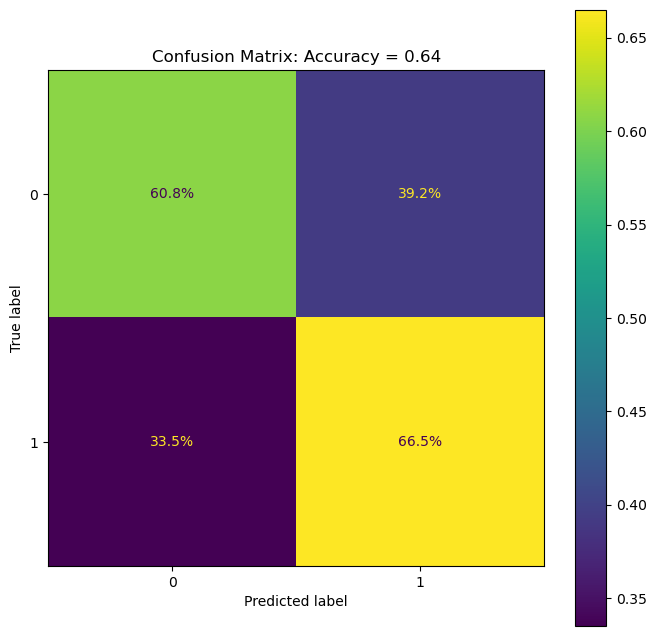

In [175]:
# Performance Test Data

vHatY = oDecTreeCls.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_non_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

In [176]:
# Define hyperparameter grid for bagging classifier
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

# Initialize list to store results
results = []

# Iterate over hyperparameter grid
for n_estimators in param_grid['n_estimators']:
    for max_samples in param_grid['max_samples']:
        for max_features in param_grid['max_features']:
            # Create Bagging classifier with current hyperparameters
            bagging_classifier = BaggingClassifier(estimator=oDecTreeCls,
                                                   n_estimators=n_estimators,
                                                   max_samples=max_samples,
                                                   max_features=max_features)
            
            # Perform GridSearchCV
            grid_search = GridSearchCV(estimator=bagging_classifier, param_grid={}, cv=5, scoring='accuracy')
            grid_search.fit(mXTrain, vYTrain)
            
            # Evaluate model performance
            best_bagging_classifier = grid_search.best_estimator_
            y_pred = best_bagging_classifier.predict(mXTest)
            accuracy = accuracy_score(vYTest, y_pred)
            
            # Store results
            results.append({
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'max_features': max_features,
                'accuracy': accuracy
            })

# Find hyperparameters with best performance
best_params = max(results, key=lambda x: x['accuracy'])

# Print results
print("Best hyperparameters:", best_params)


Best hyperparameters: {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.7, 'accuracy': 0.74875}


In [177]:
final_bagging_classifier = BaggingClassifier(estimator=oDecTreeCls,
                                             n_estimators=best_params['n_estimators'],
                                             max_samples=best_params['max_samples'],
                                             max_features=best_params['max_features'])
final_bagging_classifier = final_bagging_classifier.fit(mXTrain, vYTrain)

Accuracy  = 73.25%
Precision = 72.79%
Recall    = 74.25%
F1 Score  = 73.51%


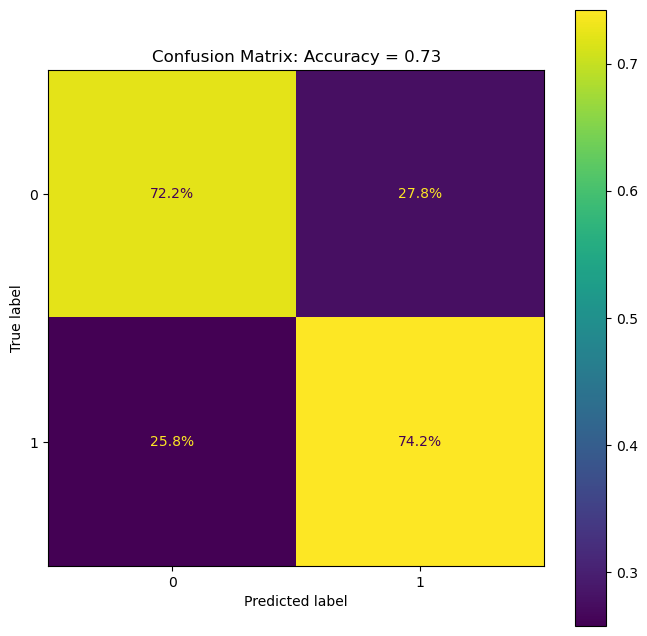

In [178]:
# Performance Test Data

vHatY = final_bagging_classifier.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_non_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

## Probability calibration

In [179]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use the calibrated classifier to predict probabilities on the test data
prob_pos = final_bagging_classifier.predict_proba(mXTest)[:, 1]

# Compute true and predicted probabilities for the positive class
true_prob_non_calibrated, pred_prob_non_calibrated = calibration_curve(vYTest, prob_pos, n_bins=10)

In [180]:
from sklearn.calibration import CalibratedClassifierCV

# Create CalibratedClassifierCV with isotonic calibration
calibrated_classifier = CalibratedClassifierCV(final_bagging_classifier, method='isotonic', cv='prefit')

# Fit the calibrated classifier to your training data
calibrated_classifier.fit(mXTrain, vYTrain)

# Make predictions on your test data
y_pred = calibrated_classifier.predict(mXTest)

Accuracy  = 73.25%
Precision = 72.79%
Recall    = 74.25%
F1 Score  = 73.51%


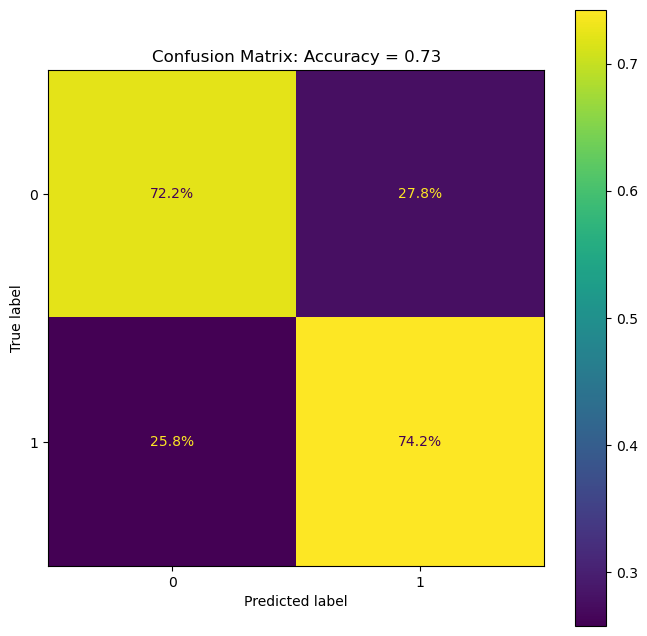

In [181]:
# Performance Test Data

vHatY = calibrated_classifier.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

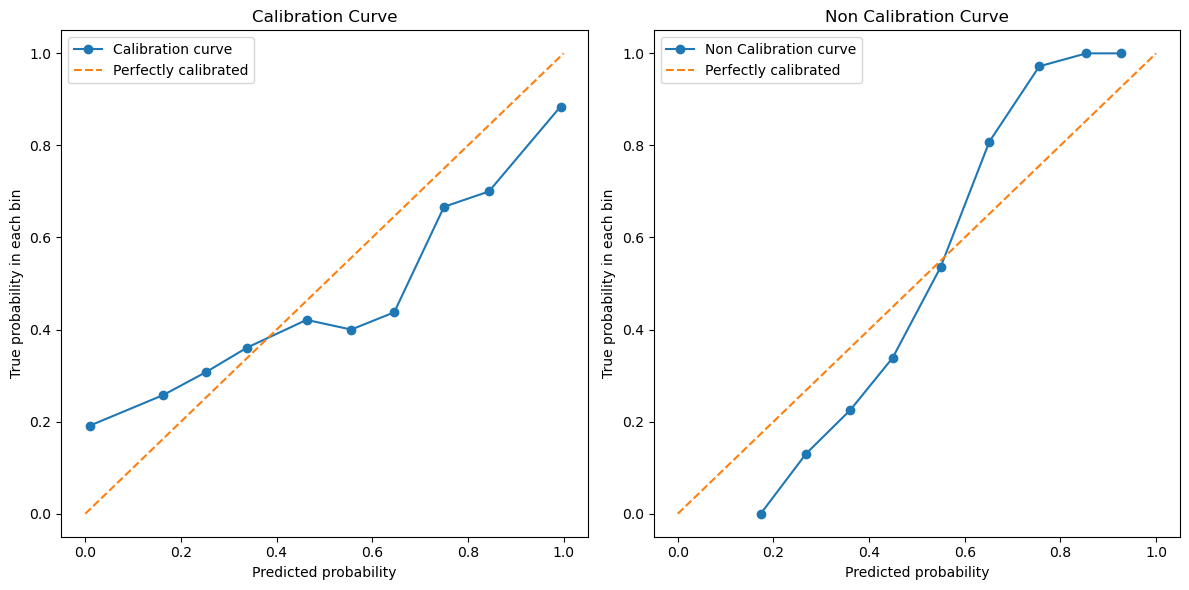

In [182]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use the calibrated classifier to predict probabilities on the test data
prob_pos = calibrated_classifier.predict_proba(mXTest)[:, 1]

# Compute true and predicted probabilities for the positive class
true_prob, pred_prob = calibration_curve(vYTest, prob_pos, n_bins=10)

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the calibration curve in the first subplot
ax1.plot(pred_prob, true_prob, marker='o', label='Calibration curve')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax1.set_xlabel('Predicted probability')
ax1.set_ylabel('True probability in each bin')
ax1.set_title('Calibration Curve')
ax1.legend()

# Plot the additional curve in the second subplot
# Replace these lines with your code to plot the additional curve
ax2.plot(pred_prob_non_calibrated, true_prob_non_calibrated, marker='o', label='Non Calibration curve')
ax2.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax2.set_xlabel('Predicted probability')
ax2.set_ylabel('True probability in each bin')
ax2.set_title('Non Calibration Curve')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


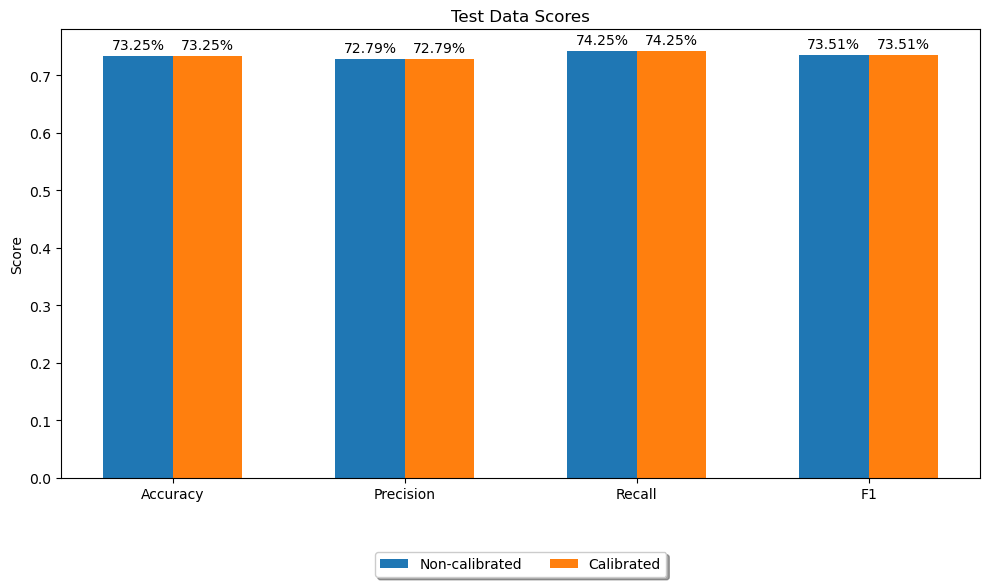

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.3

# Set the x locations for the groups
index = np.arange(len(test_data_scores_non_calibrated))

# Plot test data scores
fig, ax = plt.subplots(figsize=(10, 6))  # Only one subplot

# Test data scores
ax.bar(index - bar_width/2, test_data_scores_non_calibrated, bar_width, label='Non-calibrated')
ax.bar(index + bar_width/2, test_data_scores_calibrated, bar_width, label='Calibrated')
ax.set_title('Test Data Scores')
ax.set_xticks(index)
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
ax.set_ylabel('Score')
ax.legend()

# Function to add percentage labels to the bars
def add_percentage_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}%'.format(height * 100),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add percentage labels to the bars
add_percentage_labels(ax, ax.patches)

# Move the legend outside of the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.show()

